20180524

Adding a censor label for calculation of the C-index and for future train improvements

Adding sample_type_id which must be 01A for the primary tumor

20180525

Fixed the Data Loader so that we sort on filename before calling.  Then our indices work and our loading of the file works also. 

In [1]:
%pylab inline
import pandas as pd
import numpy as np
import fastai
import torch
from pathlib import Path
import PIL
import tqdm
import os
import json
tqdm.monitor_interval = 0

Populating the interactive namespace from numpy and matplotlib


In [2]:
from fastai.conv_learner import resnet34, resnet152, transforms_top_down, CropType, \
    tfms_from_model, ConvLearner, optim, T
from fastai.dataset import ImageClassifierData, Denormalize
from fastai.sgdr import TrainingPhase, DecayType
from lifelines.utils import concordance_index

In [3]:
def cindex_metric(preds, targs):
    try:
        cindex = concordance_index(preds, targs)
    except:
        cindex = 0.0
    return cindex

In [4]:
torch.backends.cudnn.benchmark=True
torch.cuda.set_device(1)
torch.cuda.current_device()


1

In [5]:
LIVER_PATH = Path('/DATA/BIO/GDC/liver')
LIVER_SAMPLES = LIVER_PATH/"samples"
EXP_PATH = LIVER_PATH/"exp1"
EXP_MODEL_PATH = EXP_PATH/"models"
EXP_DATA = EXP_PATH/"data"
EXP_TRAIN_DATA = EXP_DATA/"train"
EXP_TEST_DATA = EXP_DATA/"test"
PATIENT_JSON = EXP_PATH/'patient_split_censor_new.json'
TRAIN_CSV = EXP_PATH/'level_1_train.csv'
TRAIN_CSV_FULL = EXP_PATH/'level_1_train_full.csv'
TEST_CSV = EXP_PATH/'level_1_test.csv'
TEST_CSV_FULL = EXP_PATH/'level_1_test_FULL.csv'

for d in [EXP_PATH, EXP_DATA, EXP_TRAIN_DATA, EXP_TEST_DATA, EXP_MODEL_PATH]:
    if not d.exists():
        d.mkdir()

In [7]:
slides = pd.read_csv(LIVER_PATH/'slides.csv')
def get_tissue_type(x):
    return x.split('-')[4]
def get_sample_type(x):
    ''' 01A samples are "primary tumor" and we want just those samples'''
    return x.split('-')[3]

tissue_type = slides.slide_file_name.apply(get_tissue_type)
sample_type = slides.slide_file_name.apply(get_sample_type)
slides = slides.loc[(tissue_type == '01') &  (sample_type=='01A'),:].copy()

In [8]:
try:
    with open(PATIENT_JSON, 'r') as fobj:
        patients = json.load(fobj)
        train_patients = patients['train']
        val_patients = patients['val']
        test_patients = patients['test']
    train_slides = slides.loc[slides.submitter_id.isin(train_patients)]
    test_slides = slides.loc[slides.submitter_id.isin(test_patients)]

    train_csv_df = pd.read_csv(TRAIN_CSV_FULL)
    val_idx = train_csv_df.loc[train_csv_df.val_patient].index
except:
    slides['days_proxy'] = slides.days_to_death.fillna(slides.days_to_last_follow_up)
    slides = slides.loc[slides.days_proxy.notnull()].copy()
    #create censor label
    slides['event_observed'] = True
    slides.loc[slides.days_to_last_follow_up.notnull(),'event_observed'] = False    

    patients = random.permutation(list(set(slides.submitter_id)))
    split = int(0.95 * len(patients))
    val_split = int(0.8 * split)
    train_patients = patients[:split]
    val_patients = patients[val_split:split]
    test_patients = patients[split:]

    patient_split = {
        'train': list(train_patients),
        'val': list(val_patients),
        'test': list(test_patients)
    }
    with open(EXP_PATH/'patient_split_censor_new.json', 'w') as fobj:
        json.dump(patient_split, fobj)

    len(train_patients), len(val_patients), len(test_patients)
    
    train_slides = slides.loc[slides.submitter_id.isin(train_patients)]
    test_slides = slides.loc[slides.submitter_id.isin(test_patients)]
    
    
    train_items = []
    test_items = []
    num_slides = []
    samples_per_slide = 50
    for ix, patient in tqdm.tqdm_notebook(slides.iterrows(), total=len(slides)):
        sfp = LIVER_SAMPLES/patient.slide_file_name.upper()/"level_1"
        sample_files = list(sfp.iterdir())
        num_samples = len(sample_files)
        num_slides.append(num_samples)
        for fn in np.random.choice(sample_files, size=min(samples_per_slide,num_samples), replace=False):
            if patient.submitter_id in train_patients:
                dest_path = EXP_TRAIN_DATA
                train = True
                if patient.submitter_id in val_patients:
                    val = True
                else:
                    val = False
            else:
                dest_path = EXP_TEST_DATA
                train = False

            slide_id = os.path.basename(patient.slide_file_name).split('.')[0]
            img_id = os.path.basename(fn).split('.')[0]
            new_fn_base = '-'.join([slide_id, img_id]) + '.tiff'
            full_path = dest_path/new_fn_base

            if not full_path.exists():
                os.symlink(fn, dest_path/new_fn_base)

            if train:
                train_items.append({
                    'fn': str(new_fn_base),
                    'val': patient.days_proxy,
                    'val_patient': val,
                    'patient_id': patient.submitter_id,
                    'event_observed': patient.event_observed,
                    'slide_file':patient.slide_file_name
                })
            else:
                test_items.append({
                    'fn': str(new_fn_base),
                    'val': patient.days_proxy,
                    'patient_id': patient.submitter_id,
                    'event_observed': patient.event_observed,
                    'slide_file':patient.slide_file_name
                })
                
    train_csv_df = pd.DataFrame(list(random.permutation(train_items)))
     #fast.ai will sort on filenames, idx will be a mess!
    train_csv_df = train_csv_df.sort_values('fn').reset_index(drop=True)
    
    train_csv_df[['fn','val']].to_csv(TRAIN_CSV, index=False)
    train_csv_df.to_csv(TRAIN_CSV_FULL, index=False)
    val_idx = train_csv_df.loc[train_csv_df.val_patient].index
    
    test_csv_df = pd.DataFrame(test_items)
    test_csv_df = test_csv_df.sort_values('fn').reset_index(drop=True)
    
    test_csv_df[['fn','val']].to_csv(TEST_CSV, index=False)
    test_csv_df.to_csv(TEST_CSV_FULL, index=False)
    

In [9]:
f_model = resnet34
sz=256
bs=16
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, crop_type=CropType.CENTER)
md = ImageClassifierData.from_csv(
    EXP_PATH, "data/train", TRAIN_CSV, tfms=tfms, bs=bs, val_idxs=val_idx.values, continuous=True
)

In [16]:
tfms_from_stats??

Object `tfms_from_stats` not found.


In [9]:
try:
    test_csv_df
except NameError:
    test_csv_df = pd.read_csv(TEST_CSV_FULL)
    
md_test = ImageClassifierData.from_csv(
    EXP_PATH, "data/test", TEST_CSV, tfms=tfms, bs=bs, val_idxs=test_csv_df.index.values, continuous=True
)

In [10]:
from fastai.layers import AdaptiveConcatPool2d,Flatten
from torch.nn import BatchNorm1d,Dropout,ReLU,Linear,Sequential

layers = [AdaptiveConcatPool2d(), Flatten()]
layers += [BatchNorm1d(1024),
            Dropout(p=0.25), 
            Linear(in_features=1024, out_features=512), 
            ReLU(), 
            BatchNorm1d(512),
            Dropout(p=0.5), 
            Linear(in_features=512, out_features=1),
            ReLU()]
head_relu = Sequential(*layers)

In [11]:
learn = ConvLearner.pretrained(f_model, md,custom_head=head_relu)
learn.opt_fn = optim.Adam

## criteria must be from funtional library.
import torch.nn.functional as F
learn.crit = F.mse_loss

In [12]:
learn.children[-10:]

[Conv2d (3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True),
 ReLU(inplace),
 MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1)),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
     (relu): ReLU(inplace)
     (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
     (relu): ReLU(inplace)
     (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
   )
   (2): BasicBl

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                                  
    0      1119629.234116 1205922.096433



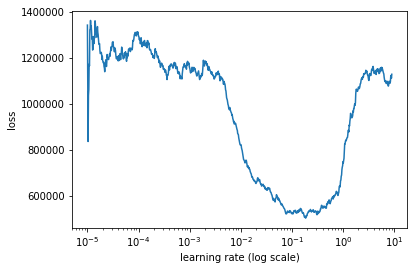

In [13]:
# set to true to try learning rate finder
if True:
    learn.save('tmp')
    lrf=learn.lr_find()
    learn.sched.plot(0)
    learn.load('tmp')

In [ ]:
lr = 0.005
learn.fit(lr, 2, cycle_len=5, use_clr=(32,5), best_save_name='liver_mse_best_1', metrics=[cindex_metric])
learn.save('liver_mse_1')

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

 47%|████▋     | 414/886 [00:14<00:16, 28.02it/s, loss=8.83e+05]

In [ ]:
lrs = np.array([lr/1000, lr/100, lr])
learn.freeze_to(-2) #unfreeze res and head layers
learn.fit(lrs, 10, cycle_len=10, use_clr=(32,10), best_save_name='liver_mse_best_2', metrics=[cindex_metric])
learn.save('liver_mse_2')

In [ ]:
lrs = np.array([lr/1000, lr/100, lr])
learn.unfreeze() #unfreeze all types, including conv layers
learn.fit(lrs, 10, cycle_len=10, use_clr=(32,10), best_save_name='liver_mse_best_3', metrics=[cindex_metric])
learn.save('liver_mse_3')

In [ ]:
from torch.autograd import Variable
def eval_model(learn, model_name):
    learn.save('tmp')
    learn.load(model_name)
    y_pred, y_targ = learn.predict_with_targs()
    learn.load('tmp')
#    return learn.crit(T(y_pred), T(y_targ)), cindex_metric(y_pred, y_targ)
    crit_data = learn.crit(Variable(T(y_pred)),Variable(T(y_targ))).data[0]
    return crit_data,cindex_metric(y_pred, y_targ)

In [ ]:
for mname in ['liver_mse_1', 'liver_mse_best_1'
              ,'liver_mse_2', 'liver_mse_best_2'
              ,'liver_mse_3', 'liver_mse_best_3'
             ]:
    print(mname,eval_model(learn, mname))

In [ ]:
learn.load('liver_mse_best_3')

Check that we have sensible values for the Cindex making sure we have sorted correctly

In [44]:
y_pred,y_targ = learn.predict_with_targs()

In [45]:
print(cindex_metric(y_pred,y_targ))

0.8387566183947543


In [46]:
print(y_pred.shape)
print(md.val_dl.dataset.n)
print(md.trn_dl.dataset.n)


(3600, 1)
3600
14261


In [47]:
y_pred_val = learn.predict_dl(md.val_dl)
val_df = train_csv_df.loc[train_csv_df.val_patient,:].copy()

In [48]:
md.val_ds.fnames[:10]

array(['data/train/TCGA-2Y-A9GS-01A-01-TS1-101.tiff', 'data/train/TCGA-2Y-A9GS-01A-01-TS1-107.tiff',
       'data/train/TCGA-2Y-A9GS-01A-01-TS1-112.tiff', 'data/train/TCGA-2Y-A9GS-01A-01-TS1-114.tiff',
       'data/train/TCGA-2Y-A9GS-01A-01-TS1-12.tiff', 'data/train/TCGA-2Y-A9GS-01A-01-TS1-120.tiff',
       'data/train/TCGA-2Y-A9GS-01A-01-TS1-127.tiff', 'data/train/TCGA-2Y-A9GS-01A-01-TS1-135.tiff',
       'data/train/TCGA-2Y-A9GS-01A-01-TS1-139.tiff', 'data/train/TCGA-2Y-A9GS-01A-01-TS1-158.tiff'],
      dtype='<U44')

In [49]:
val_df.head()

,event_observed,fn,patient_id,slide_file,val,val_patient
0,True,TCGA-2Y-A9GS-01A-01-TS1-101.tiff,TCGA-2Y-A9GS,TCGA-2Y-A9GS-01A-01-TS1.7AC59B6B-B3FF-4E31-B60...,724.0,True
1,True,TCGA-2Y-A9GS-01A-01-TS1-107.tiff,TCGA-2Y-A9GS,TCGA-2Y-A9GS-01A-01-TS1.7AC59B6B-B3FF-4E31-B60...,724.0,True
2,True,TCGA-2Y-A9GS-01A-01-TS1-112.tiff,TCGA-2Y-A9GS,TCGA-2Y-A9GS-01A-01-TS1.7AC59B6B-B3FF-4E31-B60...,724.0,True
3,True,TCGA-2Y-A9GS-01A-01-TS1-114.tiff,TCGA-2Y-A9GS,TCGA-2Y-A9GS-01A-01-TS1.7AC59B6B-B3FF-4E31-B60...,724.0,True
4,True,TCGA-2Y-A9GS-01A-01-TS1-12.tiff,TCGA-2Y-A9GS,TCGA-2Y-A9GS-01A-01-TS1.7AC59B6B-B3FF-4E31-B60...,724.0,True


In [50]:
val_df.loc[:,'y_pred']=y_pred_val.copy()

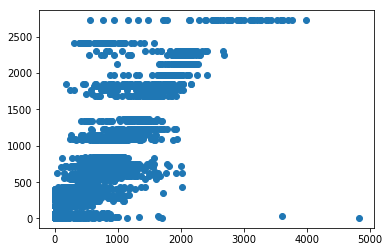

In [51]:
plt.scatter(val_df.y_pred,val_df.val)

In [52]:
print(concordance_index(val_df.y_pred,val_df.val))
print(cindex_metric(val_df.y_pred,val_df.val))


0.8387566183947543
0.8387566183947543


### TEST

In [36]:
y_pred = learn.predict_dl(md_test.val_dl)
test_df = test_csv_df.copy()
test_df['y_pred'] = y_pred

y_pred.shape, test_df.shape

((900, 1), (900, 6))

In [38]:
yp_pred = test_df.groupby('patient_id').y_pred.min()
yp_targ = test_df.groupby('patient_id').val.mean()
concordance_index(yp_pred, yp_targ )

0.9166666666666666

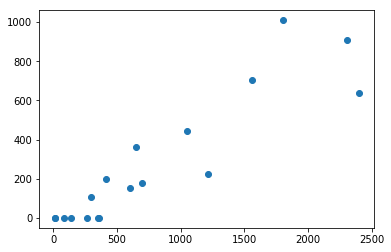

In [39]:
scatter(yp_targ, yp_pred)

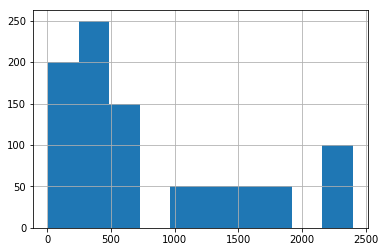

In [40]:
test_df.val.hist()

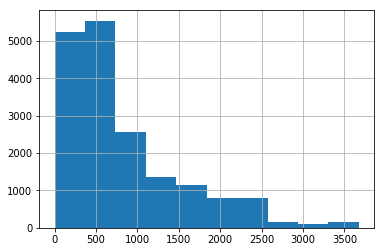

In [41]:
train_csv_df.val.hist()